Based on this video tutorial:

https://www.youtube.com/watch?v=4OXntFVfFio&t=1088s

# Training a faster-rccn model
This jupiter notebook trains a Detectron2 faster-rccn model using the images from the "train" folder given in the assignment.

The training images was split from being 50 train images to 40 train and 10 validation images.


This is mainly only to show that I have trained and that it works. I haved a my trained model to the .zip file that will be run in testing.

## Setup
Only 3 thing needs to be done:
1. Make sure that no other sessions is running and run this using GPU.
1. Mount the google drive.
3. Have the .zip file in the root directory of your google drive or specify the path in the !unzip.

The time of training this model depends on amount of iterations set. To save the model make sure the "want_to_save" = true. The model will save to google drive when finished. If "want_to_save" = false it will not save the model but only show that its training a model. Its not necessary to save it because the Bildenalyse_assignment2_resources.zip already comes with my trained model.

In [ ]:
want_to_save_model = False # If true the model is saved to your google drive after the training is done. Else it will not be saved.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive

Mounted at /content/gdrive


In [ ]:
import os.path
from os import path
if path.exists("/content/Bildeanalyse-assignment2-resources") == False:
  !unzip gdrive/MyDrive/Bildeanalyse-assignment2-resources.zip -d ./

Archive:  gdrive/MyDrive/Bildeanalyse-assignment2-resources.zip
   creating: ./Bildeanalyse-assignment2-resources/rcnn/
   creating: ./Bildeanalyse-assignment2-resources/rcnn/Images-coco-annotated/
   creating: ./Bildeanalyse-assignment2-resources/rcnn/Images-coco-annotated/test/
  inflating: ./Bildeanalyse-assignment2-resources/rcnn/Images-coco-annotated/test/_annotations.coco.json  
  inflating: ./Bildeanalyse-assignment2-resources/rcnn/Images-coco-annotated/test/1_jpg.rf.b220dd8f30b134dee1cfe37218674097.jpg  
  inflating: ./Bildeanalyse-assignment2-resources/rcnn/Images-coco-annotated/test/10_jpg.rf.3bfa421381ec50b718c6db0bc0f19e4d.jpg  
  inflating: ./Bildeanalyse-assignment2-resources/rcnn/Images-coco-annotated/test/11_jpg.rf.c62a6f7a0e438dec98458a97a36c0798.jpg  
  inflating: ./Bildeanalyse-assignment2-resources/rcnn/Images-coco-annotated/test/12_jpg.rf.462613c99e5ff3bbed6ecc22f1be71d2.jpg  
  inflating: ./Bildeanalyse-assignment2-resources/rcnn/Images-coco-annotated/test/13_jpg.

## The code

In [ ]:
# Installing dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
#print(torch.__version__, torch.cuda.is_available())
!gcc --version

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8 MB 22 kB/s 
     |████████████████████████████████| 6.6 MB 27.2 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.5.0+cu101 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.5.0+cu101 which is incompatible.
     |████████████████████████████████| 274 kB 4.2 MB/s 
  Created wheel fo

In [ ]:
# Installing detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2 MB 2.5 MB/s 
     |████████████████████████████████| 50 kB 5.0 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220305-py3-none-any.whl size=61214 sha256=04983af0c67b7fc02a52d1fbdc4f47019e74258233859f5fb2e43e72fc640f4a
  Stored in directory: /root/.cache/pip/wheels/b5/b7/6e/43b1693d06fac3633af48db68557513b0a37ab38b0a8b798f9
Successfully built fvcore


In [ ]:
# Imports
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "Bildeanalyse-assignment2-resources/rcnn/Images-coco-annotated/train/_annotations.coco.json", "Bildeanalyse-assignment2-resources/rcnn/Images-coco-annotated/train")
register_coco_instances("my_dataset_val", {}, "Bildeanalyse-assignment2-resources/rcnn/Images-coco-annotated/valid/_annotations.coco.json", "Bildeanalyse-assignment2-resources/rcnn/Images-coco-annotated/valid")


WARNING [03/17 14:13:21 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/17 14:13:21 d2.data.datasets.coco]: Loaded 40 images in COCO format from Bildeanalyse-assignment2-resources/rcnn/Images-coco-annotated/train/_annotations.coco.json


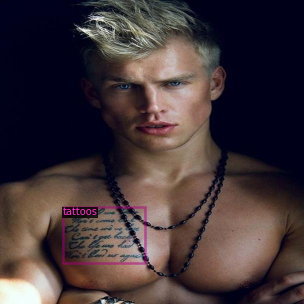

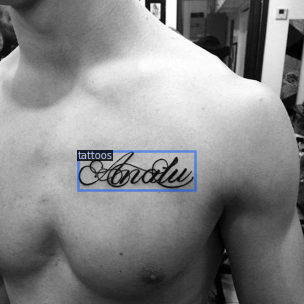

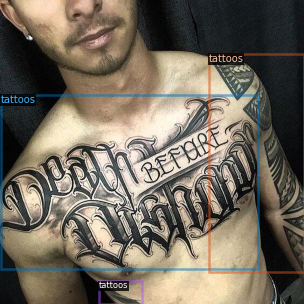

In [ ]:
#Checking the data by visualizing it.
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
# Importing Trainer Module to enable validation.
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:
# Training
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05




cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 #your number of classes + 1

cfg.TEST.EVAL_PERIOD = 500


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[03/17 14:13:25 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:22, 19.0MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_pre

[03/17 14:13:57 d2.engine.train_loop]: Starting training from iteration 0
[03/17 14:15:34 d2.utils.events]:  eta: 1:21:21  iter: 19  total_loss: 1.792  loss_cls: 0.905  loss_box_reg: 0.720  loss_rpn_cls: 0.111  loss_rpn_loc: 0.017  time: 4.8024  data_time: 0.0339  lr: 0.000020  max_mem: 7210M


In [ ]:
if want_to_save_model == True:
  !cp -av output gdrive/MyDrive/rcnn_model/

If you want to use the model you just saved you can find it in the rcnn_model folder on your google drive. Take this "output" folder and racplace it with the one in "/content/Bildeanalyse-assignment2-resources/rcnn/model/"